## Setup

In [ ]:
# ---------------------------------------------------
# 📦 LIBRERÍAS
# ---------------------------------------------------
from google.cloud import bigquery
from io import BytesIO
from PIL import Image
from google.api_core import exceptions
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google import genai
from google.genai.types import Part, GenerateContentConfig

PROJECT = "lmes-aiforlmes-d-f86"
LOCATION = "europe-west1"
AI_MODEL_NAME = "gemini-2.5-flash-image"

# --- PROMPTS (sin cambios) ---
PICTOGRAM_PROMPT = """
=== TASK: CREATE TECHNICAL DRAWING WITH DIMENSION LINES ===

**PHASE 1: GENERATE BASE ILLUSTRATION**

--- CORE INSTRUCTION ---
Your goal is to create a highly detailed, black and white line art illustration of the product based on the provided reference image, and then accurately overlay precise dimension lines and labels as specified in the "ADD DIMENSIONS" section.
--- STYLE GUIDELINES (Base Illustration) ---
1.  **Line Art:** Generate a clean, crisp, black and white line drawing for the product. No colors, no shadows, no fills, no gradientsm no sparkles.
2.  **Detail Level:** Emphasize an extremely high level of detail. Trace the reference image as if converting a photograph into a precise technical drawing.
3.  **Perspective:** Maintain the exact perspective and angle of the object as seen in the reference image.
--- CONTENT GUIDELINES (Base Illustration) ---
1.  **Product Only:** The illustration must only depict the product itself.
--- OUTPUT GUIDELINES (Base Illustration) ---
1.  **Canvas Containment:** Ensure the entire product illustration is fully contained within the image canvas, leaving ample space for dimensions.

**PHASE 2: ADD TECHNICAL DIMENSION LINES (COTAS)**

Now overlay professional dimension lines on the illustration:

**DIMENSION LINE STYLE (ISO 129-1 / ANSI Y14.5 Standard):**
- Line type: Thin, solid black lines (50% width of product outline)
- Spacing: Mantain the spacing of the original image, do not overcrowd
- Clearance: Ensure NO overlap with product illustration or other dimension lines

**TEXT FORMATTING:**
- Color: Solid black
- Size: Proportional to image (readable but not dominant)
- Format: "[EXACT_VALUE] + [ UNIT MEASURE]" (example: "150 cm", "42.5 mm", "8 cm")
- Position: Centered along dimension line or adjacent (perpendicular orientation for vertical lines)
- Alignment: Horizontal text for horizontal lines, rotated 90° for vertical lines

**MANDATORY CONSTRAINTS:**
✓ Do NOT round, approximate, or modify any values
✓ Add (space + UNIT MEASURE) after each dimension value
✓ Draw ONLY ONE dimension line per measurement (no duplicates)
✓ If a value is missing, empty, "Not specified", or "N/A", SKIP that dimension entirely
✓ Verify dimensional logic if it is not clear do not draw the line (dimension line length must be proportional to the actual measurement value (e.g., a 150 cm width should have a longer line than a 30 cm depth))
✓ Do NOT draw dimension lines that are disproportionately too long or too short relative to the stated measurement value
✓ If the dimension line placement would create visual confusion or spatial inconsistency, OMIT that dimension
✓ If placement is ambiguous or uncertain, OMIT that dimension line 

**DIMENSIONS TO ADD (exact values with each corresponding unit measure):**

"""

# reference = 97976348
reference = 98935772
# reference = 98935773
# reference =  98085961 # no carac
# reference = 94031529 # no carac
# reference = 94301837

# path_img = "pruebas_imagenes/97976348-p-01.jpg"
path_img = "pruebas_imagenes/98935772-p-03.jpg"
# path_img = "pruebas_imagenes/98935773-p-02.jpg"
# path_img = "pruebas_imagenes/98085961-p-02.jpg" # no carac 
# path_img= "pruebas_imagenes/94031529-p-01.jpg"
# path_img = "pruebas_imagenes/94301837-p-03.tif.jpg"

genai_client = genai.Client(vertexai=True, project=PROJECT, location="us-central1")

client = bigquery.Client(project=PROJECT, location="EU")

In [51]:
# sql_opus_dimensiones = f"""
# SELECT productReferenceBu, t.type, media_item.type, media_item.url, media_item.label
# FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_MEDIA_V1_com_adeo_CatalogsBroadcast_ProductCoreMediaValue` as t,
# UNNEST(media) AS media_item
# WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) = TIMESTAMP("2025-09-19") and media_item.type = "photo"
# """
# opus_dimensiones = client.query(sql_opus_dimensiones).to_dataframe()
# opus_dimensiones

In [52]:

sql_dimension_reference = f"""
SELECT 
    productReferenceBu, att.code as code_char, att.name as name_char, d.value.double as value_char
FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_ATTRIBUTE_V1_com_adeo_CatalogsBroadcast_ProductCoreAttributeValue`,
    UNNEST(attributes) AS att,
    UNNEST(att.data) AS d
WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) 
  BETWEEN TIMESTAMP("2025-11-19") AND TIMESTAMP("2025-12-20") and
  # Altura en cm, Ancho en cm, Profundidad en cm, Altura total en cm, Anchura total en cm, Profundidad total en cm
  att.code in("00053","00054", "00055", "00640", "03650", "14266") 
  and productReferenceBu = cast({reference} as STRING)
"""


dimension = client.query(sql_dimension_reference).to_dataframe()
# Puede haber duplicados en dimension, los quitamos
dimension = dimension.drop_duplicates(subset=['code_char'])

In [65]:
dimensiones = {dimension.loc[i, "name_char"]: dimension.loc[i, "value_char"] for i in dimension.index}
# Convert if it's a float AND has no decimals
dimensiones= {
    k: (int(v) if isinstance(v, float) and v.is_integer() else v) 
    for k, v in dimensiones.items()
}

In [66]:
dimensiones

{'Altura (en cm)': np.float64(137.8),
 'Anchura (en cm)': 105,
 'Profundidad (en cm)': 48}

## Funciones auxiliares

In [55]:
def get_pictogram_with_dimensions_from_image(dimensions: dict, image: Image.Image) -> Image.Image:
    """Genera un pictograma con cotas a partir de una imagen de referencia y sus dimensiones"""
    prompt_text = PICTOGRAM_PROMPT
    
    for key, value in dimensiones.items():
        prompt_text += f"{key}: {value}\n"
    print(dimensiones.items())
    # Convertir la imagen PIL a bytes en formato JPEG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    contents = [
        Part.from_text(text=prompt_text), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/jpeg")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            # config=GenerateContentConfig(
            #     safety_settings=[
            #         {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'threshold': 'BLOCK_NONE'},
            #         {'category': 'HARM_CATEGORY_HARASSMENT', 'threshold': 'BLOCK_NONE'},
            #         {'category': 'HARM_CATEGORY_HATE_SPEECH', 'threshold': 'BLOCK_NONE'},
            #         {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'threshold': 'BLOCK_NONE'},
            #     ]
            # )
        )
        return response
    
    except Exception as e:
        print(f"⚠️ Intento fallido con error de API: {e}")

In [59]:
response = get_pictogram_with_dimensions_from_image(dimensiones, Image.open(path_img))

dict_items([('Altura (en cm)', np.float64(137.8)), ('Anchura (en cm)', np.float64(105.0)), ('Profundidad (en cm)', np.float64(48.0))])


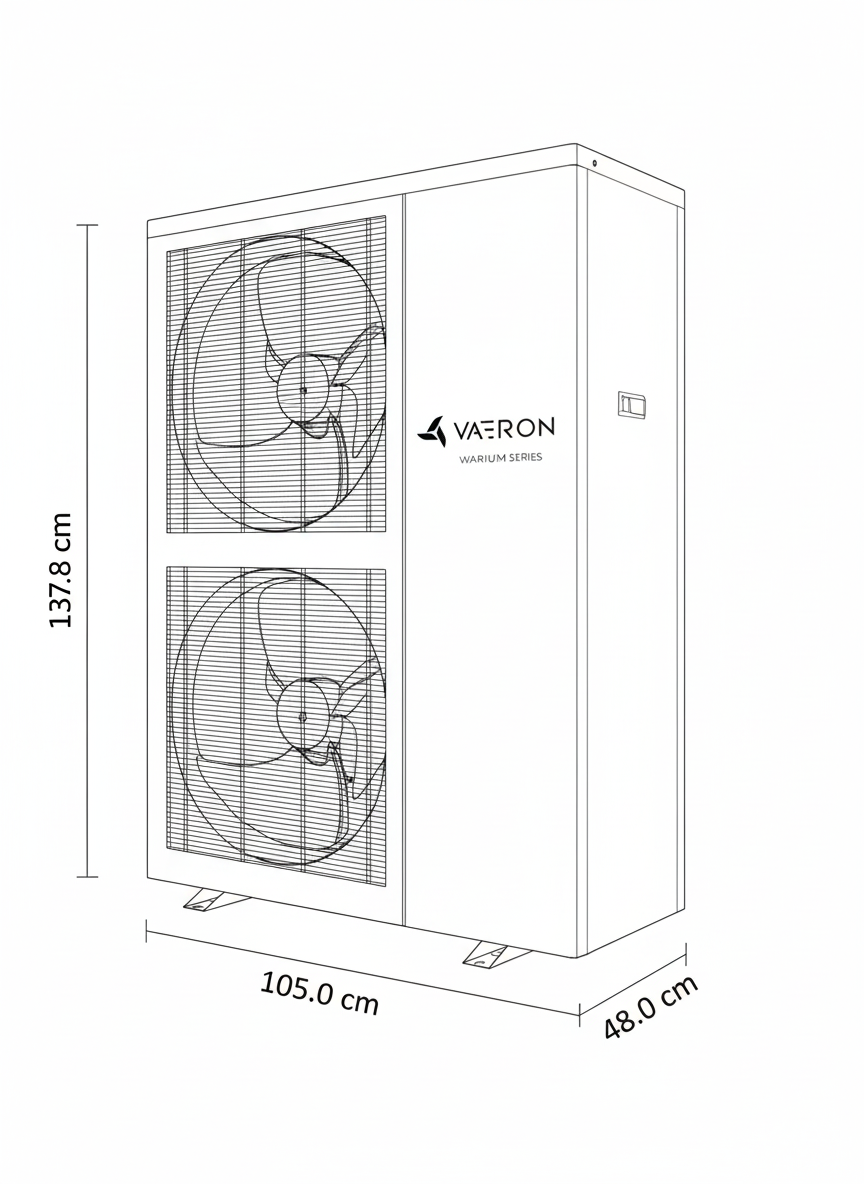

In [60]:
# Extraer la imagen de la respuesta
if response and response.candidates:
    # Obtener la primera parte de la respuesta que contiene la imagen
    for part in response.candidates[0].content.parts:
        if part.inline_data:
            # Convertir los bytes de la imagen a PIL Image
            image_data = part.inline_data.data
            generated_image = Image.open(BytesIO(image_data))
            
            # Mostrar la imagen
            display(generated_image)
            
            # Opcionalmente, guardar la imagen
            generated_image.save(f"./pruebas_imagenes/pictograma_con_cuotas_{reference}.png")